In [6]:
from morphi_lab.av import AV
from morphi_lab.segmenter import Segmenter
import cv2 
from PIL import Image
import numpy as np 
import os
cwd = os.getcwd()
parent_dir = os.path.dirname(cwd)

from diffusers import StableDiffusionInpaintPipeline
diffusion_pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    # torch_dtype=torch.float16,
)


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1.  functions

In [11]:
# plot img and mask 
import matplotlib.pyplot as plt

def plot_frame(img_path):
    av = AV(img_path)
    av.show_result()
    
def plot_frame_and_mask(img, mask):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img)
    ax[1].imshow(mask)
    plt.show()
    
    
# transform frame
def transform_frame(frame,
                     prompt="coca cola can, high resolution, logo visible, red and white colors",
                     conf=0.15):
    # detect and segment
    segmenter = Segmenter(conf=conf)
    segmenter.read_img(frame)
    segmenter.segment()
    segmenter.project_segmentations()

    # convert mask to PIL image
    mask = segmenter.segmentation_result[0].masks.data[0].cpu().numpy()
    mask = mask.astype(np.uint8)*255
    mask = np.stack((mask,)*3, axis=-1)
    mask = Image.fromarray(mask)
    mask = mask.convert('RGB')
    mask = mask.resize((512, 512)) 

    # resize segmenter.img to 448x640
    frame = cv2.resize(segmenter.img, (640, 448))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = Image.fromarray(frame)
    frame = frame.convert('RGB')
    frame = frame.resize((512, 512))

    # difuse mask
    difused_frame = diffusion_pipe(prompt=prompt, image=frame, mask_image=mask).images[0]
    
    # resize difused_frame to 640x448
    difused_frame = difused_frame.resize((640, 448))
    return difused_frame


# 1.  Image

In [12]:
# path to image 
img_path = parent_dir + "/test_data/test_input/test_can.png"

# load in image
img = cv2.imread(img_path)

# transform frame
difused_frame = transform_frame(img)

100%|██████████| 50/50 [02:50<00:00,  3.41s/it]


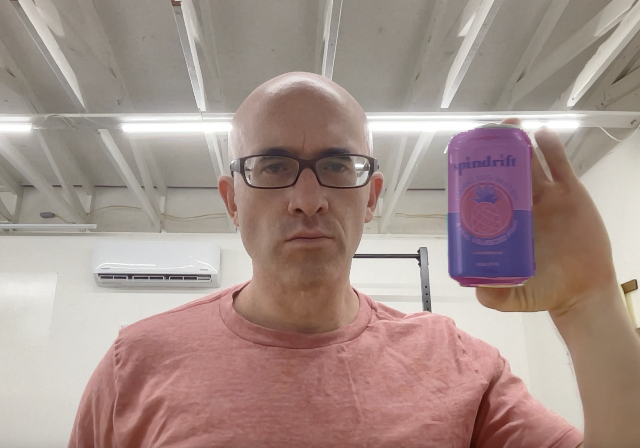

In [15]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = Image.fromarray(img)
img = img.convert('RGB')
img

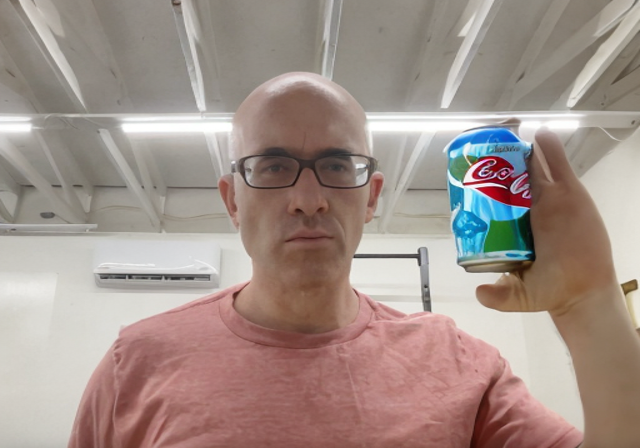

In [13]:
difused_frame.resize((640, 448))

# 2.  Video

In [ ]:
import cv2
from morphi_lab.segmenter import Segmenter
from tqdm import tqdm
import fire
from diffusers import StableDiffusionInpaintPipeline
diffusion_pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    # torch_dtype=torch.float16,
)

def difuse_video(input_path, output_path):
    # read in video
    cap = cv2.VideoCapture(input_path)

    # get total number of frames
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # setup tqdm
    pbar = tqdm(total=total_frames)

    # get frame width and height from img
    success, img = cap.read()

    # get frame width and height from img
    frame_width = img.shape[1]
    frame_height = img.shape[0]

    # define codec and create VideoWriter object
    size = (frame_width, frame_height)
    result = cv2.VideoWriter(output_path,
                             cv2.VideoWriter_fourcc(*'MJPG'),
                             30, size)

    # loop through video
    while success is not None:
        try:
            # segment frame
            difused_frame = transform_frame(img)

            # write frame
            result.write(difused_frame)
        except Exception as e:
            print(e, flush=True)
            break

        # read in next frame
        ret, img = cap.read()

        # update tqdm
        pbar.update(1)

    # release video
    cap.release()
    result.release()
    cv2.destroyAllWindows()

    # close tqdm
    pbar.close()

In [ ]:
# load in test video 1.avi
input_path = parent_dir + "/test_data/test_input/test_video_1.avi"

# read in video, show in notebook
cap = cv2.VideoCapture(input_path)
while True:
    ret, frame = cap.read()
    if not ret:
        break
    cv2.imshow("frame", frame)
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break 